In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib
import networkx as nx
import matplotlib
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
fpath = "../../input/Osaka.ttc"
font_prop = matplotlib.font_manager.FontProperties(fname=fpath)
import japanize_matplotlib
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import glob
import ast
import MeCab
import re
import swifter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import datetime
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannot import add_stat_annotation
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [2]:

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
stopwords = list(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:

from logging import getLogger, StreamHandler, DEBUG, INFO, FileHandler, Formatter
logger = getLogger(__name__)
sthandler = StreamHandler()
sthandler.setLevel(DEBUG)

filehandler = FileHandler("activity_ja_20210608.log")
filehandler.setLevel(DEBUG)

formatter = Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
filehandler.setFormatter(formatter)
sthandler.setFormatter(formatter)

logger.addHandler(sthandler)
logger.addHandler(filehandler)
logger.setLevel(DEBUG)
logger.propagate = False

logger.debug('hello')  

2021-08-11 11:46:02,688:18:DEBUG:hello


In [4]:
with open('tmp_output/df_vaccine_%s.pickle'%"all", mode='rb') as f:
    tmp_df = pickle.load(f)

In [5]:
tmp_pairs = [tuple(i) for i in tmp_df.loc[:, ["user_screen_name", "retweeted_status_screen_name"]].values]
tmp_pairs = tmp_pairs + [tuple([i[1], i[0]]) for i in tmp_pairs]
tmp_valuecounts = pd.Series(tmp_pairs).value_counts()

# RTが2回以上のもの（相互に1回ずつも含む）
tmp_tmp_pairs = tmp_valuecounts[tmp_valuecounts > 1].index
tmp_tmp_pairs  = set(tmp_tmp_pairs)

unique_pair = [tuple(i) for i in tmp_df.loc[:, ["user_screen_name", "retweeted_status_screen_name"]].values]
unique_pair = set(pd.Series(unique_pair)[pd.Series(unique_pair).isin(tmp_tmp_pairs)].values)

len(unique_pair)

118385

In [6]:
# ネットワークを作成
G = nx.DiGraph()
G.add_edges_from(unique_pair)
G1 = nx.k_core(G,k=3)
len(G1.nodes())

12017

In [7]:
tmp_tmp_df = pd.read_csv("RT_vaccine_all_1.csv")

In [8]:
selected_clusters = [2, 7, 4, 11, 9]

In [9]:
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(2, "Neutral")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(4, "Pro_Vax")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(7, "Anti-Vax")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(9, "Right")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(11, "Left")

In [10]:
selected_clusters = ["Pro_Vax", "Left", "Anti-Vax", "Right", "Neutral"]

In [11]:
# 誰がいるか
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    subG = G1.subgraph(tmp_cluster["Label"].values)
    display.display(pd.Series(dict(subG.in_degree())).sort_values(ascending=False)[:10])
    print(len(tmp_cluster)/ len(tmp_tmp_df))
    print("===="*20)

Pro_Vax


io302              913
mph_for_doctors    871
EARL_Med_Tw        657
VaccineWatch       531
sekkai             492
rikomrnk           340
TOTB1984           284
minesoh            280
tabitora1013       253
MIKITO_777         189
dtype: int64

0.18623616543230423
Left


BB45_Colorado      533
influenzer3        382
masahirono         311
GoodBye_Nuclear    300
keyaki1117         297
KamiMasahiro       296
masaru_kaneko      289
koichi_kawakami    262
RawheaD            170
kzooooo            146
dtype: int64

0.16018973121411334
Anti-Vax


nakamuraclinic8    1293
JunSakura_Japan     947
TTrumpSJapan        562
someone5963         507
BABYLONBU5TER       413
yoshimichi0409      302
binbou415           297
OdNezu              268
pecko178            254
sate_tv             215
dtype: int64

0.19464092535574604
Right


sonkoubun          379
SatoMasahisa       379
anonymous_post2    242
dappi2019          196
vG2AZlCr4F3hx6Y    175
Tomo20309138       161
bellbelo99         148
hiroyoshimura      146
smith796000        111
bluesayuri         103
dtype: int64

0.10859615544645086
Neutral


ReutersJapan       1677
nhk_news           1458
YahooNewsTopics    1360
nikkei              882
livedoornews        879
jijicom             800
afpbbcom            681
Sankei_news         537
nhk_seikatsu        354
Newsweek_JAPAN      347
dtype: int64

0.25422318382291753


In [12]:
# RT
dict_top_rt = {}
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    display.display(tmptmptmp_df["text"].value_counts()[:10])
    
    dict_top_rt[cluster] = tmptmptmp_df["text"].value_counts()[:10]
    print("======="*30)

Pro_Vax


rt @koike_masato: 「新型コロナウイルス」で検索すると悲観的なニュースがわんさか出てくるけど、正式病名の「covid-19」で検索すると冷静な情報が出てくるし、ウイルス名の「sars-cov-2」で検索するとワクチンや治療薬の最新の成果に触れられる。不安の量はア…    804
rt @mph_for_doctors: 新型コロナウイルスの大流行の翌年に、ワクチンが開発されるとします。ワクチンのお蔭で感染者数は激減。以降は散発的な流行のみとなり、報道される機会も減ります。結果40年後にワクチンを打たない人が多く現れ、再度流行します。「愚…            585
rt @wicyek28ekip: 私は反ワクチンから生還したのですが、今回のコロナウィルスの件で「反ワクチン」だった知人たちが大パニック。bcgが効くとか、肺炎球菌がーとかいう記事を見ては「打ってない！」「どれもやってない」と。ピンチなのは子どもだよ。菌活してる、腸内環境…      569
rt @vaccinewatch: 新型コロナワクチン、日本でも承認申請が行われ、うまくいけば来年前半から実際に使用されることになりそうです。ここでもう一度注意喚起です。これからワクチンに関するショッキングな画像・動画やデマ情報がどんどん流れてくると思いますが、「安易に拡…       538
rt @andre_makino: 恐らくこの新型コロナ問題で一番風刺がきいていると思ったニュース。「ミュンヘンで計画されていた『反ワクチン接種デモ』が、新型コロナウイルス蔓延の影響で中止になった」                                             489
rt @earl_med_tw: ノーベル賞を受賞したリュック・モンタニエ氏が「新型コロナウイルスは人工ウイルス」とおっしゃってるようですが、特にご自身で解析されたわけでもないですし、この方は現在は反ワクチンやホメオパシーをはじめとするさまざまなオカルトに浸かっておられる方です…    473
rt @earl_med_tw: 新型コロナ予防しようと…bcgワクチン接種ミス成人に“絶対禁止”の皮下注射 - 毎日新聞                                                   

Left


rt @soundandfury68: もうこういうのやめていただけますか？今回は生命かかってるんで。新型コロナ、ワクチン製造は厚労省天下り先海外製は無視（news ポストセブン） - yahoo!ニュース                                         416
rt @wanpakuten: 安倍首相 新型コロナワクチン開発などに８億ドル超の支援表明 「アビガン」をおよそ80か国に提供する方向のほか、途上国に向けて総額15億4000万ドルを超える支援を決めたと説明しました。ーーーワクチン開発の方はいいとしても、途上国に15億…         363
rt @rawhead: これはちょっと嫌なニュース。上海の研究者がコロナ回復者175人の血液を調べたところ、1/3の被験者で中和抗体の量がやたらと低くて、再感染予防になるかどうかに懸念が残るとのことだと。ワクチン開発にも影響しそうなデータ                        328
rt @kzooooo: 危なくね？「2021年前半開始」国民全員に接種新型コロナワクチン巡る厚労省プラン - 毎日新聞                                                                                    321
rt @koichi_kawakami: 興味深い。twitter界では、東電福島原発事故による放射線被曝を心配する人たちを「放射脳」と呼ぶ人と、hpvワクチンの副反応を心配する人たちを「反ワクチン」と呼ぶ人と、重症化するまでコロナウィルスのpcr検査を必要ないと言う人が、かな…    302
rt @koichi_kawakami: 【核酸・ウィルスベクターワクチンについて考えること(1)】アンジェス社はdnaワクチン、アストラゼネカ社はアデノウィルスベクターワクチンを開発しています。どちらもsars-cov-2がもつ遺伝子を人間に導入し、人間の細胞でsars-c…     270
rt @bb45_colorado: 日本のワクチン開発能力は、昔から一貫して世界ではかなり低いのだから日本が新型コロナのワクチンを主導するなんて完全に無意味な嘘の世界。                           

Anti-Vax


rt @junsakura_japan: fdaがビルゲイツコロナウイルステストプログラムを中止米国はマイクロチップ入りワクチンは回避できそうです。日本の政治家はsdgsのバッジを着けてる方も多く、メディアはゲイツを推してるので、防ぐには国民の覚醒が大事ですね。sdgs…      1103
rt @junsakura_japan: 「2021年前半開始」国民全員に接種新型コロナワクチン巡る厚労省プラン2021年は中国共産党創立100年公明党とビル＆メリンダ・ゲイツ財団との繋がりsdgsワクチン接種強制を防止しないと。国民から選択権を奪ってはいけません！…         699
rt @nakamuraclinic8: "ポーランド大統領,反ワクチン表明"「いかなる強制ワクチンにも賛成しない。コロナに対するワクチンは強制的であってはならない。個人的にはインフルのワクチンも打たない」この人すばらしい政治家だけど、近いうちに心臓麻痺が起こるんじゃないか…     567
rt @junsakura_japan: トランプ氏、コロナウイルスは「ワクチンなしで立ち去る」と語った                                                                                           557
rt @junsakura_japan: トランプ大統領は反ワクチン声明。whoの思想や計画を知れば反ワクチンで当然。                                                                                    441
rt @nakamuraclinic8: "コロナワクチンの接種を拒否すればどうなりますか?"法律家"就学/就労は不可,公共サービスが利用できないのはもちろん,罰金刑や禁固刑もあり得る"生存率99%以上の感染症なのに,なぜこんなにワクチンを打たせようと必死なのかそこを考…       422
rt @jijitsuhoudou: コロナウイルスには「特許」が存在した。（陰謀ではなく事実として）。その特許の申請には、あのビルゲイツ財団が資金提供していた。遺伝子の「特許」を持つ団体が、ワクチンを製造する。これを「マッチポンプ」と

Right


rt @satomasahisa: 今日、某自民党議員から、新型コロナウイルスに関し「過激な発言が続いてますね」と言われました。ただ、新型の感染症は、治療薬もワクチンもない以上、危機管理で先手先手を打ってやらないと、取り返しがつかないことにもなりかねない。タリバン佐藤と言われ…    428
rt @anonymous_post2: 米司法省、中国公安当局の指示のもと動いていた中国人ハッカー2人を起訴日本企業も被害標的となった業界はｉｔ関連や医薬品、防衛、太陽光エネルギー、ゲームソフトなど最近では新型コロナウイルス感染症のワクチン研究関連も                 322
rt @sonkoubun: 超極爆速報！！！ロシア製の史上初の新型コロナのワクチンを注射したプーチン大統領の娘が死亡した。これで習近平に復習しないといけないな                                                               263
rt @dappi2019: ケント・ギルバート「世界中が情報を出して新型コロナのワクチン開発の協力してるが、中国だけは自分達だけでワクチン開発して市場独占をしようとしてる。怒りを感じる」中国発なのに中国には反省の色が全くない。むしろチャンスとばかりに軍事挑発したりやって…      261
rt @anonymous_post2: 中国、中南米諸国がコロナワクチンを入手できるよう１０億ドルの融資発表新型コロナで打撃の国々を支援～ネットの反応「マッチポンプｗｗｗ」「中国製ワクチンを買うカネを中国共産党が貸す⇒そして借金のカタに国を盗られるシステム」             255
rt @dappi2019: 須田慎一郎「日本のコロナワクチン研究が箸にも棒にも掛からないのは“ワクチン研究は生物化学兵器に関連するので軍事研究の一部”とみなされてるから。国立大学協会会長は『ウイルス研究も否定はおかしい』と批判してる。我々は実害を被ってる」日本学術会議は不…     230
rt @smith796000: 新型コロナウイルスのワクチンできたよ。早くも治験が始まるそうです。詳しくはこの記事読んでね。みんな仕事が早いねぇ！！人類万歳！                                      

Neutral


rt @amasehimika147: 「恒久的な特効薬となりうる新型コロナワクチンの実現は不可能」と私が繰り返し予言していた通りになりそうですね。                                                                    844
rt @amasehimika147: 集団免疫の獲得も不可能ですし、確実な予防効果のあるワクチンの実現も不可能です。人類は決してコロナウイルスに勝てない。                                                                822
rt @yahoonewstopics: 【コロナワクチン 全員無料に】                                                                                                          782
rt @amasehimika147: 「新型コロナワクチンに副作用があっても責任負わない」＝アストラゼネカロイター通信によると、アストラゼネカは「各国と締結した新型コロナウイルスのワクチン供給契約には、ワクチンの副作用が発生した場合、自社が責任を負わないという内容が含まれ…    716
rt @reutersjapan: コロナワクチン、年内の実用化は無理ｗｈｏ幹部が明言                                                                                                   701
rt @reutersjapan: 米看護師、ファイザー製ワクチン接種1週間後にコロナ感染＝報道                                                                                              468
rt @amasehimika147: who、新型コロナの「特効薬存在し得ない可能性」世界保健機関（who）のテドロス事務局長は「人々の感染を防ぐのに役立つ有効なワクチンを複数保有できればと、われわれは皆望んでいる」とした上で、「しかし現時点で特

In [13]:
import sys
import json
import requests
sys.path.append("../../config/")
import translate_api

api_key=translate_api.key

url="https://translation.googleapis.com/language/translate/v2"
url += "?key=" + api_key
url += "&q=%s" 
url += "&source=ja&target=en"

In [14]:
dict_top_rt_en = {}

In [17]:
error_num = 0
for cluster in dict_top_rt:
    dict_top_rt_en[cluster] = []
    for text_, i in tqdm(dict_top_rt[cluster].iteritems()):
        text_ = text_.replace("#", "")
        query = copy.copy(url%text_)
        query = query.replace("&gt;", "")
        query = query.replace("#", "")
        query = query.replace("&lt;", "")
        try:
            rr=requests.get(query)
            unit_aa=json.loads(rr.text)
            result = unit_aa["data"]["translations"][0]["translatedText"]
            dict_top_rt_en[cluster].append(result)
        except:
            if str(rr.status_code) == "429":
                break
            else:
                error_num += 1
                dict_top_rt_en[cluster].append("error: "+str(rr.status_code))
                logger.debug(str(text_))
                logger.debug("error: "+str(rr.status_code)+ " " + str(unit_aa["error"]['errors']))

In [15]:
tmp_stop_words = ["corona", "virus", "coronavirus","covid", "covid-19", "covid19", "vaccine", "vax", "vaccination"]#, "
tmp_stop_words += ["新型", "コロナウイルス", "コロナウィルス", "新型コロナ", "新型コロナウィルス", "新型コロナウイルス"]
tmp_stop_words += ["コロナ", "ワクチン", "ウイルス", "ウィルス"]
#tmp_stop_words += list(nltk_stopwords.words('english'))
tmp_stop_words += STOPWORDS
tmp_stop_words = list(set(tmp_stop_words))
tmp_stop_words2 = ["amp"]
tmp_stop_words += tmp_stop_words2

In [16]:
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(0, 100%%, %d%%)" % (50 * ((dictionary[word] - min(dictionary.values())) / (max(dictionary.values()) - min(dictionary.values()))))
    return my_tf_color_func_inner

In [18]:
tmp_list = [0] * len(selected_clusters)
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    tmp_count = tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:50]
    #tmp_all_words = [[i]* int(np.log(tmp_count[i]+1)*10) for i in tmp_count.index]
    tmp_all_words = [[i]* int(tmp_count[i]/20) for i in tmp_count.index]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    #tmp_all_words = [i for i in tmp_all_words if i in list(feature_array)]
    tmp_all_words = list(pd.Series(tmp_all_words)[~pd.Series(tmp_all_words).isin(set(tmp_stop_words + list(tmp_cluster["Label"])))].values)
    text = " ".join(tmp_all_words)
    
    tmp_list[c] = copy.copy(text)
    #tmp_list.append(text)
    
tfidf_vectorizer = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)#, lowercase=False, sublinear_tf=True)
tmp_tfidf = tfidf_vectorizer.fit_transform(tmp_list)

Pro_Vax
Left
Anti-Vax
Right
Neutral


In [19]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())

In [20]:
def translate_word(x):
    text_ = x.replace("#", "")
    query = copy.copy(url%text_)
    try:
        rr=requests.get(query)
        unit_aa=json.loads(rr.text)
        result = unit_aa["data"]["translations"][0]["translatedText"]
        return result
    except:
        return ""

Pro_Vax


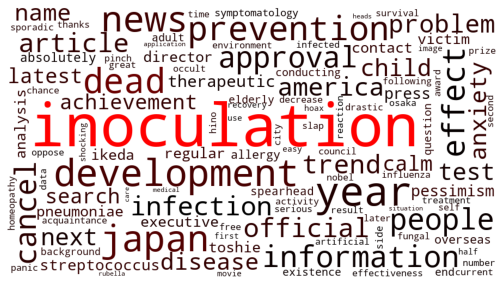

Left


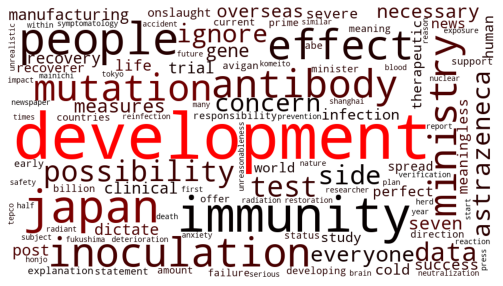

Anti-Vax


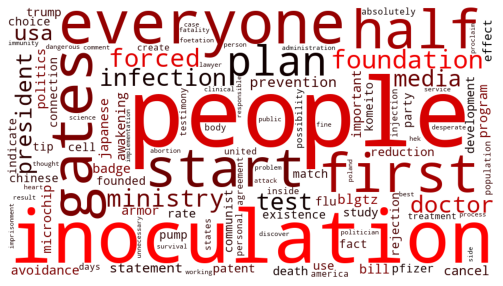

Right


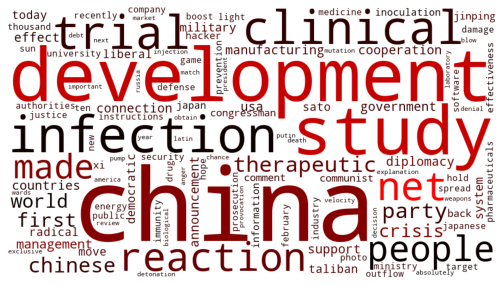

Neutral


KeyError: 'house'

In [25]:
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:500].index for i in sub ]
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"] for i in sub ]
    tmp_count = tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:50]
    #tmp_all_words = [[i]* int(np.log(tmp_count[i]+1)*10) for i in tmp_count.index]
    tmp_all_words = [[i]* int(tmp_count[i]/20) for i in tmp_count.index]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = list(pd.Series(tmp_all_words)[pd.Series(tmp_all_words).isin(list(feature_array))].values)#[i for i in tmp_all_words if i in list(feature_array)]
    tmp_all_words = list(pd.Series(tmp_all_words)[~pd.Series(tmp_all_words).isin(set(tmp_stop_words + list(tmp_cluster["Label"])))].values)
    #tmp_all_words = [i for i in tmp_all_words if i not in set(tmp_stop_words + list(tmp_cluster["Label"]))]
    #tmp_counts = np.log(pd.Series(tmp_all_words).value_counts())
    #tmp_all_words = [[i]*int(np.log(tmp_counts[i]+2)*20) for i in tmp_counts.index]
    
    top_100_words = list(pd.Series(tmp_all_words).value_counts()[:100].index)
    top_100_words_translated = [translate_word(i) for i in top_100_words]
    top_100_words_translated = [i.lower() for i in top_100_words_translated]
    dict_word_translated = dict(zip(top_100_words, top_100_words_translated))
    
    top_100_words_to_join = [dict_word_translated[i] for i in tmp_all_words if i in top_100_words]
    
    text = " ".join(top_100_words_to_join) #" ".join(tmp_all_words)#[i for sub in tmp_all_words for i in sub])
    text = " ".join([i for i in text.split() if i not in tmp_stop_words])
    
#     tmp_tmp_count = np.log(tmp_count[j].toarray()[0][tfidf_sorting[::-1][:n]])
#     tmp_tmp_count = [i/max(tmp_tmp_count) for i in tmp_tmp_count]
    
    #tfidf_sorting = np.argsort(tmp_tfidf.toarray()[c])[::-1]
    tmp_words = list(feature_array)
    tmptmp_tfidf = list(tmp_tfidf.toarray()[c])
    tmp_dict = dict(zip(tmp_words, tmptmp_tfidf))
    
    tmp_dict_ = {}
    for i in tmp_dict:
        if i in top_100_words:
            tmp_dict_[dict_word_translated[i]] = tmp_dict[i]
            
    tmp_dict__ = {}
    for i in tmp_dict_:
        tmp_dict__[i] = tmp_dict_[i]
        if len(i.split()) > 1:
            for j in i.split():
                if j not in tmp_stop_words:
                    tmp_dict__[j] = tmp_dict_[i]
        if len(i.split("-")) > 1:
            for j in i.split():
                if j not in tmp_stop_words:
                    tmp_dict__[j] = tmp_dict_[i]

    
    #fpath = "../input/Osaka.ttc"
    
    wordcloud = WordCloud(
        background_color="white",
        #font_path=fpath, 
        width=900, 
        height=500,
        collocations = False,
        color_func=my_tf_color_func(tmp_dict__)
    ).generate(text)

    plt.figure(figsize=(9,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    plt.savefig("figures/wordcloud_ja_%s.png"%str(c), format="png", dpi=300, bbox_inches='tight')
    plt.show()


In [130]:
selected_clusters[4:]

['Neutral']

Neutral


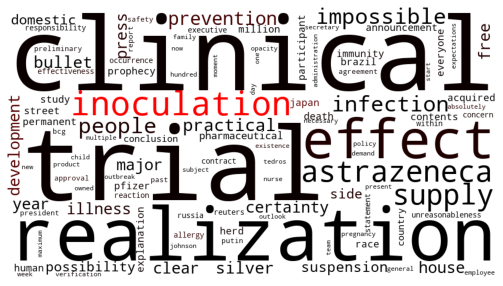

In [24]:
for c, cluster in enumerate(selected_clusters[4:]):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:500].index for i in sub ]
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"] for i in sub ]
    tmp_count = tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:50]
    #tmp_all_words = [[i]* int(np.log(tmp_count[i]+1)*10) for i in tmp_count.index]
    tmp_all_words = [[i]* int(tmp_count[i]/20) for i in tmp_count.index]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = list(pd.Series(tmp_all_words)[pd.Series(tmp_all_words).isin(list(feature_array))].values)#[i for i in tmp_all_words if i in list(feature_array)]
    tmp_all_words = list(pd.Series(tmp_all_words)[~pd.Series(tmp_all_words).isin(set(tmp_stop_words + list(tmp_cluster["Label"])))].values)
    #tmp_all_words = [i for i in tmp_all_words if i not in set(tmp_stop_words + list(tmp_cluster["Label"]))]
    #tmp_counts = np.log(pd.Series(tmp_all_words).value_counts())
    #tmp_all_words = [[i]*int(np.log(tmp_counts[i]+2)*20) for i in tmp_counts.index]
    
    top_100_words = list(pd.Series(tmp_all_words).value_counts()[:100].index)
    top_100_words_translated = [translate_word(i) for i in top_100_words]
    top_100_words_translated = [i.lower() for i in top_100_words_translated]
    dict_word_translated = dict(zip(top_100_words, top_100_words_translated))
    
    top_100_words_to_join = [dict_word_translated[i] for i in tmp_all_words if i in top_100_words]
    
    text = " ".join(top_100_words_to_join) #" ".join(tmp_all_words)#[i for sub in tmp_all_words for i in sub])
    text = " ".join([i for i in text.split() if i not in tmp_stop_words])
    
#     tmp_tmp_count = np.log(tmp_count[j].toarray()[0][tfidf_sorting[::-1][:n]])
#     tmp_tmp_count = [i/max(tmp_tmp_count) for i in tmp_tmp_count]
    
    #tfidf_sorting = np.argsort(tmp_tfidf.toarray()[c])[::-1]
    tmp_words = list(feature_array)
    tmptmp_tfidf = list(tmp_tfidf.toarray()[c])
    tmp_dict = dict(zip(tmp_words, tmptmp_tfidf))
    
    tmp_dict_ = {}
    for i in tmp_dict:
        if i in top_100_words:
            tmp_dict_[dict_word_translated[i]] = tmp_dict[i]
            
    tmp_dict__ = {}
    for i in tmp_dict_:
        tmp_dict__[i] = tmp_dict_[i]
        if len(i.split()) > 1:
            for j in i.split():
                if j not in tmp_stop_words:
                    tmp_dict__[j] = tmp_dict_[i]
                if len(j.split("-")) > 1:
                    for k in j.split("-"):
                        if k not in tmp_stop_words:
                            tmp_dict__[k] = tmp_dict_[i]
        if len(i.split("-")) > 1:
            for j in i.split("-"):
                if j not in tmp_stop_words:
                    tmp_dict__[j] = tmp_dict_[i]

    
    #fpath = "../input/Osaka.ttc"
    
    wordcloud = WordCloud(
        background_color="white",
        #font_path=fpath, 
        width=900, 
        height=500,
        collocations = False,
        color_func=my_tf_color_func(tmp_dict__)
    ).generate(text)

    plt.figure(figsize=(9,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("figures/wordcloud_ja_%s.png"%str(4), format="png", dpi=300, bbox_inches='tight')
    plt.show()
